In [6]:
# -*- coding: utf-8 -*-
"""interpolation_benchmark.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1gyIF1PDHFPb1HaI1zmvhonzV3E1AXj4t
"""
import zipfile
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# --- Setup: Extract GPUPy and add to path ---
# Assuming GPUPy.zip contains GPUPy/src/numerical_methods/interpolation.py
# and GPUPy/src/numerical_methods/interpolation_gpu.py in the correct structure.
with zipfile.ZipFile("/content/GPUPy.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Add the extracted content's root directory to the Python path.
# This allows importing modules like GPUPy.src.numerical_methods.interpolation.
sys.path.append("/content")

Starting interpolation benchmark...
Running interpolation benchmarks...
N          CPU Lin (s)     GPU Lin (s)     CPU Spline (s)  GPU Spline (s) 
100        0.000110        0.000828        0.000191        0.001050       
1000       0.000135        0.000920        0.000265        0.001104       
10000      0.000819        0.000999        0.001228        0.001652       
100000     0.013958        0.002782        0.014826        0.011401       
1000000    0.132680        0.014837        0.154002        0.110120       
5000000    0.855653        0.085277        0.869714        1.001315       


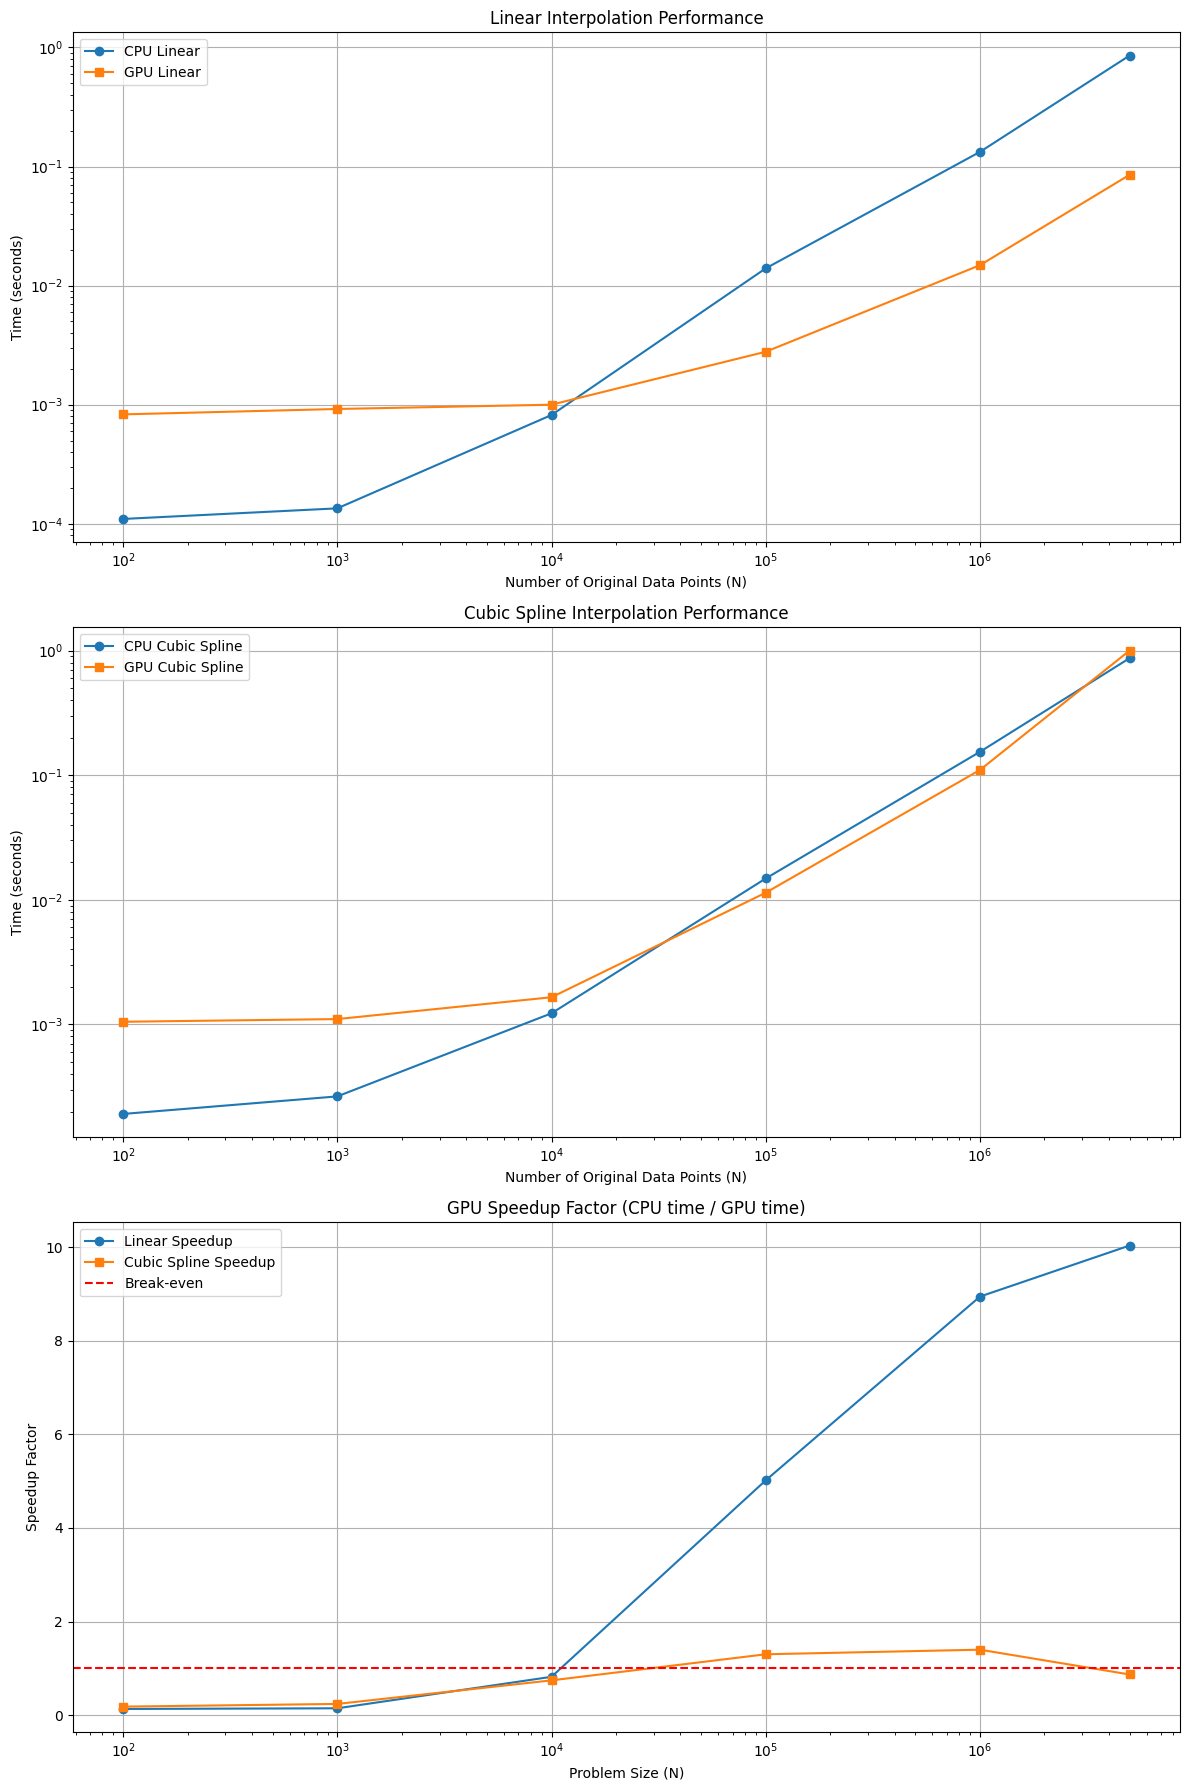

Benchmark complete. Results saved to interpolation_benchmark_results.png


In [7]:


# --- CuPy Availability Check ---
# Check if CuPy is installed and import it. This flag will control whether
# GPU benchmarks are attempted.
try:
    import cupy as cp
    _CUPY_AVAILABLE = True
except ImportError:
    _CUPY_AVAILABLE = False
    print("Warning: CuPy not found. GPU benchmarks will be skipped.")

# --- Import Interpolation Modules ---
# Import the high-level interpolation functions from your GPUPy project.
# These functions handle the internal dispatch to CPU or GPU implementations.
from GPUPy.src.numerical_methods.interpolation import linear_interpolation, spline_interpolation


# --- Helper Function: benchmark ---
# This function measures the average execution time of a given method.
def benchmark(method_func, *args, repeats=5, **kwargs):
    """
    Benchmark a function by measuring its execution time.

    Parameters:
        method_func (callable): The function to benchmark.
        *args: Positional arguments to pass to the function.
        repeats (int): The number of times to repeat the measurement for averaging. Defaults to 5.
        **kwargs: Keyword arguments to pass to the function.

    Returns:
        float: The average execution time in seconds.
    """
    # Perform an initial call outside the timing loop. This can help warm up
    # the function (e.g., JIT compilation in some cases, or initial data transfer).
    method_func(*args, **kwargs)

    # Now, measure the actual execution times.
    durations = []
    for _ in range(repeats):
        start = time.perf_counter() # Use perf_counter for high-resolution timing
        method_func(*args, **kwargs)
        durations.append(time.perf_counter() - start)

    # Calculate and return the average duration.
    avg_time = sum(durations) / repeats
    return avg_time


# --- Helper Function: plot_benchmark_results ---
# This function generates and saves plots of the benchmark results.
def plot_benchmark_results(sizes, cpu_times_lin, gpu_times_lin,
                           cpu_times_spline, gpu_times_spline,
                           speedup_lin, speedup_spline):
    """
    Create visualizations of the benchmark results for interpolation.

    Args:
        sizes (list): List of problem sizes (N) tested.
        cpu_times_lin (list): List of CPU times for linear interpolation.
        gpu_times_lin (list): List of GPU times for linear interpolation.
        cpu_times_spline (list): List of CPU times for cubic spline interpolation.
        gpu_times_spline (list): List of GPU times for cubic spline interpolation.
        speedup_lin (list): List of GPU speedup factors for linear interpolation.
        speedup_spline (list): List of GPU speedup factors for cubic spline interpolation.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18)) # Create a figure with 3 subplots

    # Plot 1: Execution times for Linear Interpolation
    ax1.plot(sizes, cpu_times_lin, 'o-', label='CPU Linear')
    ax1.plot(sizes, gpu_times_lin, 's-', label='GPU Linear')
    ax1.set_title('Linear Interpolation Performance')
    ax1.set_xlabel('Number of Original Data Points (N)')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('log') # Use logarithmic scale for x-axis (problem size)
    ax1.set_yscale('log') # Use logarithmic scale for y-axis (time)
    ax1.grid(True) # Add grid for better readability
    ax1.legend() # Display legend

    # Plot 2: Execution times for Cubic Spline Interpolation
    ax2.plot(sizes, cpu_times_spline, 'o-', label='CPU Cubic Spline')
    ax2.plot(sizes, gpu_times_spline, 's-', label='GPU Cubic Spline')
    ax2.set_title('Cubic Spline Interpolation Performance')
    ax2.set_xlabel('Number of Original Data Points (N)')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.legend()

    # Plot 3: GPU Speedup Factor (CPU time / GPU time)
    ax3.plot(sizes, speedup_lin, 'o-', label='Linear Speedup')
    ax3.plot(sizes, speedup_spline, 's-', label='Cubic Spline Speedup')
    ax3.axhline(y=1, color='r', linestyle='--', label='Break-even') # Red dashed line at speedup = 1
    ax3.set_title('GPU Speedup Factor (CPU time / GPU time)')
    ax3.set_xlabel('Problem Size (N)')
    ax3.set_ylabel('Speedup Factor')
    ax3.set_xscale('log')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.savefig('interpolation_benchmark_results.png') # Save the figure to a file
    plt.show() # Display the figure


# --- Main Benchmark Runner Function ---
def run_interpolation_benchmarks():
    """
    Run comprehensive benchmarks comparing CPU and GPU interpolation performance
    for linear and cubic spline methods across different problem sizes.
    """
    # Define problem sizes (N) for the original data points (x, y).
    # The number of points to interpolate (x_new) will be 2 * N.
    # Added 5 million to the sizes. Be mindful of GPU memory limits for very large N.
    sizes = [100, 1000, 10000, 100000, 1000000, 5000000]

    # Initialize lists to store benchmark results for plotting.
    cpu_times_lin = []
    gpu_times_lin = []
    cpu_times_spline = []
    gpu_times_spline = []

    print("Running interpolation benchmarks...")
    # Print table header for console output.
    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format(
        "N", "CPU Lin (s)", "GPU Lin (s)", "CPU Spline (s)", "GPU Spline (s)"))

    # Iterate through each defined problem size (N).
    for N in sizes:
        # Create original data (x_orig, y_orig) for the given N.
        x_orig = np.linspace(0, 100, N)
        y_orig = np.sin(x_orig)
        # Create new points (x_new) where interpolation will be performed.
        # This is typically larger than the original data set.
        x_new = np.linspace(0, 100, N * 2)

        # --- Benchmark Linear Interpolation ---
        # Run CPU linear interpolation and store its time.
        cpu_time_lin = benchmark(linear_interpolation, x_orig, y_orig, x_new, use_gpu=False)
        cpu_times_lin.append(cpu_time_lin)

        # Attempt GPU linear interpolation if CuPy is available.
        gpu_time_lin = np.nan # Initialize with NaN (Not a Number) if GPU is skipped or fails.
        if _CUPY_AVAILABLE:
            try:
                gpu_time_lin = benchmark(linear_interpolation, x_orig, y_orig, x_new, use_gpu=True)
            except Exception as e:
                # Catch any errors during GPU execution and inform the user.
                print(f"GPU linear interpolation failed for N={N}: {e}. Skipping GPU benchmark for this size.")
        else:
            print(f"Skipping GPU linear benchmark for N={N} (CuPy not available).")
        gpu_times_lin.append(gpu_time_lin)


        # --- Benchmark Cubic Spline Interpolation ---
        # Run CPU cubic spline interpolation. Note: SciPy's CubicSpline can be
        # computationally intensive for very large N due to matrix inversions.
        cpu_time_spline = benchmark(spline_interpolation, x_orig, y_orig, x_new, bc_type='natural', use_gpu=False)
        cpu_times_spline.append(cpu_time_spline)

        # Attempt GPU cubic spline interpolation if CuPy is available.
        gpu_time_spline = np.nan # Initialize with NaN.
        if _CUPY_AVAILABLE:
            try:
                # The GPU spline currently calculates coefficients on CPU, then evaluates on GPU.
                gpu_time_spline = benchmark(spline_interpolation, x_orig, y_orig, x_new, use_gpu=True)
            except Exception as e:
                print(f"GPU cubic spline interpolation failed for N={N}: {e}. Skipping GPU benchmark for this size.")
        else:
            print(f"Skipping GPU cubic spline benchmark for N={N} (CuPy not available).")
        gpu_times_spline.append(gpu_time_spline)

        # Print the benchmark results for the current problem size to the console.
        print("{:<10} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(
            N, cpu_time_lin, gpu_time_lin, cpu_time_spline, gpu_time_spline))

    # Calculate the GPU speedup factor (CPU_time / GPU_time).
    # Handle cases where GPU time is zero or NaN to avoid division by zero or invalid results.
    speedup_lin = [cpu/gpu if gpu > 0 and not np.isnan(gpu) else np.nan for cpu, gpu in zip(cpu_times_lin, gpu_times_lin)]
    speedup_spline = [cpu/gpu if gpu > 0 and not np.isnan(gpu) else np.nan for cpu, gpu in zip(cpu_times_spline, gpu_times_spline)]

    # Generate and save the performance plots.
    plot_benchmark_results(sizes, cpu_times_lin, gpu_times_lin,
                           cpu_times_spline, gpu_times_spline,
                           speedup_lin, speedup_spline)

    # Return a dictionary containing all collected benchmark data.
    return {
        'sizes': sizes,
        'cpu_times_lin': cpu_times_lin,
        'gpu_times_lin': gpu_times_lin,
        'cpu_times_spline': cpu_times_spline,
        'gpu_times_spline': gpu_times_spline,
        'speedup_lin': speedup_lin,
        'speedup_spline': speedup_spline
    }


# --- Main Execution Block ---
# This block ensures that run_interpolation_benchmarks() is called only when the
# script is executed directly (not when imported as a module).
if __name__ == "__main__":
    print("Starting interpolation benchmark...")
    results = run_interpolation_benchmarks()
    print("Benchmark complete. Results saved to interpolation_benchmark_results.png")